# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 3.1MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

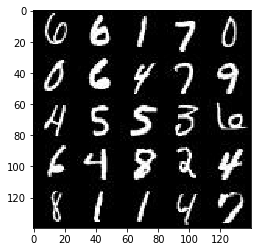

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

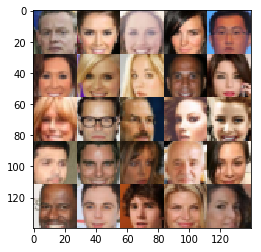

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learn_rate = tf.placeholder(tf.float32, None, name="learn_rate")

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    def leaky_relu(input_layer):
            return tf.maximum(alpha * input_layer, input_layer)
        
    def hidden_layer(input_layer, filters):
            input_layer = tf.nn.dropout(input_layer, 0.3)
            conv = tf.layers.conv2d(input_layer, filters, kernel_size=5, strides=2, padding='same')
            conv = tf.layers.batch_normalization(conv, training=True)
            return leaky_relu(conv)
    alpha = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1
        print(images.shape)
        x = tf.layers.conv2d(images, 64, kernel_size=5, strides=2, padding='same')
        x = leaky_relu(x)
        print(x.shape)
        conv_1 = hidden_layer(x, 128)
        print(conv_1.shape)
        conv_2 = hidden_layer(conv_1, 256)
        print(conv_2.shape)
        #conv_3 = hidden_layer(conv_2, 512)
        
        product = int(conv_2.shape[1] * conv_2.shape[2] * conv_2.shape[3])
        flat = tf.reshape(conv_2, (-1, product))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        print(out.shape)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

(?, 28, 28, 3)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
(?, 28, 28, 3)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #n_units = 128
    alpha=0.02
    def leaky_relu(input_layer):
            return tf.maximum(alpha * input_layer, input_layer)
        
    def hidden_layer(input_layer, filters, kernel_size=5, strides=2, padding='same'):
            conv = tf.layers.conv2d_transpose(input_layer, filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias = False)
            conv = tf.layers.batch_normalization(conv, training=is_train)
            return leaky_relu(conv)
            
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 4*4*512)
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        
        conv_1 = hidden_layer(x, 256, 4, 1, "valid")
        conv_2 = hidden_layer(conv_1, 128, 4)
        conv_3 = hidden_layer(conv_2, 128, 4, 1)
        #conv_4 = hidden_layer(conv_3, 64, 2, 1)
        #logits = hidden_layer(conv_2, out_channel_dim, 4)
        
        logits = tf.layers.conv2d_transpose(conv_3, out_channel_dim, kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


# Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real = discriminator(input_real)
    print(input_real.shape, g_model.shape)
    d_model_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_real, labels=tf.ones_like(d_model_real)) * 0.9)
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 28, 28, 4)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
(?, 28, 28, 4) (?, 28, 28, 4)
(?, 28, 28, 4)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    print(input_z)
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0 
    
    losses = []
    
    input_real, input_z, learning_rate_placeholder = model_inputs( data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_placeholder,  beta1)
    
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1 
                #scaling images up from (-0.5, 0.5) to (-1, 1)
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_placeholder: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_placeholder: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, learning_rate_placeholder: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, learning_rate_placeholder: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                
                if steps % 100 == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                    #show model
                 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 28, 28, 1)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
(?, 28, 28, 1) (?, 28, 28, 1)
(?, 28, 28, 1)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 1.0398
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 1.1104
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.9953
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 1.0746
Tensor("input_z:0", shape=(?, 112), dtype=float32)


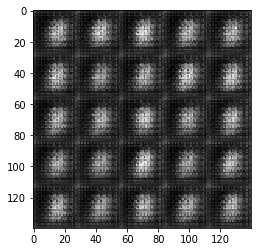

Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 1.6403... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.7039
Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 0.8205
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 1.1226
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.9958
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 1.1527
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 1.0627
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.9858
Tensor("input_z:0", shape=(?, 112), dtype=float32)


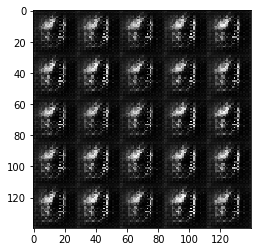

Epoch 1/2... Discriminator Loss: 1.5387... Generator Loss: 0.8301
Epoch 1/2... Discriminator Loss: 1.5383... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 1.5139... Generator Loss: 0.8489
Epoch 1/2... Discriminator Loss: 1.4227... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.5220... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.5441... Generator Loss: 0.9302
Tensor("input_z:0", shape=(?, 112), dtype=float32)


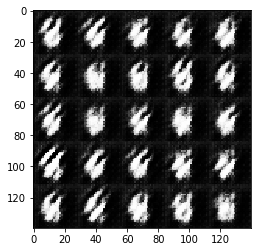

Epoch 1/2... Discriminator Loss: 1.5777... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.9464
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 1.1523
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.6456
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.5617
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.6147
Tensor("input_z:0", shape=(?, 112), dtype=float32)


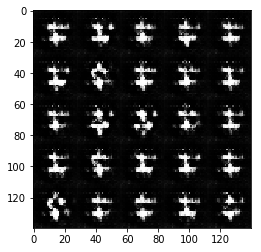

Epoch 1/2... Discriminator Loss: 1.5972... Generator Loss: 0.4245
Epoch 1/2... Discriminator Loss: 1.7558... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 1.5834... Generator Loss: 0.9485
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.7587
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.8108
Tensor("input_z:0", shape=(?, 112), dtype=float32)


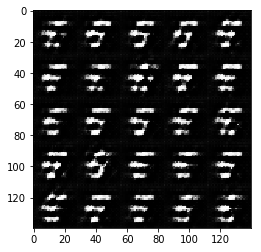

Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 1.2641
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 1.1306
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 1.0374
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 1.2209
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.6860
Tensor("input_z:0", shape=(?, 112), dtype=float32)


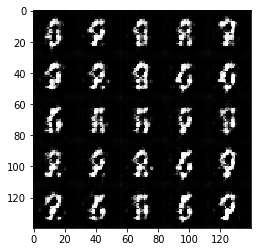

Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 0.8188
Epoch 1/2... Discriminator Loss: 0.7550... Generator Loss: 1.5614
Epoch 1/2... Discriminator Loss: 1.0500... Generator Loss: 1.1392
Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 1.4727
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 1.3475... Generator Loss: 0.9924
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.8655
Tensor("input_z:0", shape=(?, 112), dtype=float32)


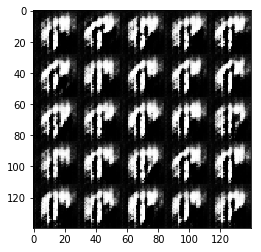

Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 1.1348
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 1.4509
Epoch 1/2... Discriminator Loss: 1.6100... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.4791... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.5157... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.8826
Tensor("input_z:0", shape=(?, 112), dtype=float32)


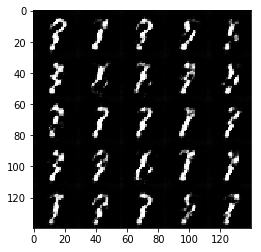

Epoch 1/2... Discriminator Loss: 1.5710... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 0.7434
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.9259
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.8756
Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 1.0525
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 0.7092
Tensor("input_z:0", shape=(?, 112), dtype=float32)


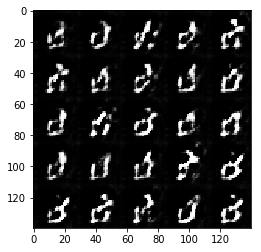

Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 0.9825
Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 1.1000
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 0.9413
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 0.8156
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 1.0503
Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 1.5059
Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 1.0500
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 1.0401
Tensor("input_z:0", shape=(?, 112), dtype=float32)


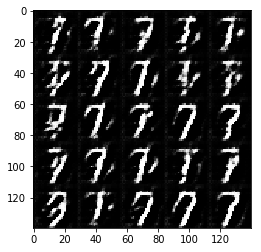

Epoch 1/2... Discriminator Loss: 1.6280... Generator Loss: 0.8759
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.8583
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.9097
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 1.0512
Tensor("input_z:0", shape=(?, 112), dtype=float32)


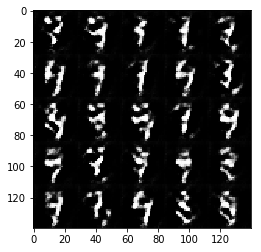

Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.9182
Epoch 1/2... Discriminator Loss: 1.5451... Generator Loss: 0.5499
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 1.1269
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 1.0581
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 0.9818
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 0.8736
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 0.9791
Tensor("input_z:0", shape=(?, 112), dtype=float32)


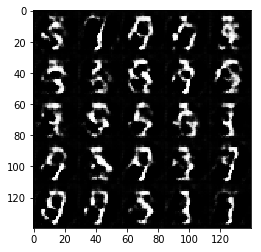

Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 1.6310... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 1.1360
Epoch 1/2... Discriminator Loss: 1.1395... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.8130
Tensor("input_z:0", shape=(?, 112), dtype=float32)


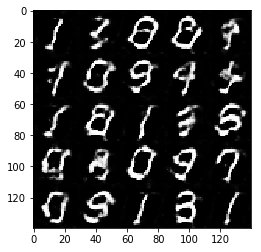

Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.6075
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.6341... Generator Loss: 0.6173
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.4767... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.6687
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.7008
Tensor("input_z:0", shape=(?, 112), dtype=float32)


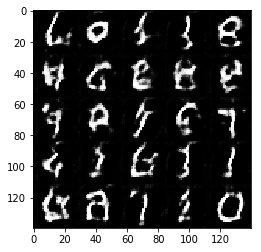

Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 0.7335
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 1.4816... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.6874
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.8903
Tensor("input_z:0", shape=(?, 112), dtype=float32)


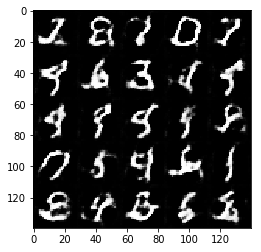

Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 0.8985
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 1.2910... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.6087
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.8148
Tensor("input_z:0", shape=(?, 112), dtype=float32)


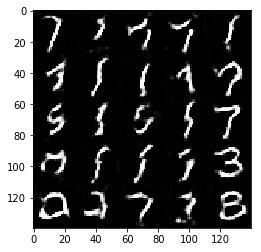

Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.5909
Epoch 1/2... Discriminator Loss: 1.3721... Generator Loss: 0.7664
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.8483
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.8559
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.6063
Tensor("input_z:0", shape=(?, 112), dtype=float32)


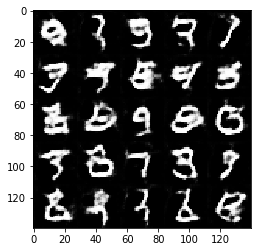

Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.6505
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.3958... Generator Loss: 0.8355
Epoch 1/2... Discriminator Loss: 1.4381... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 0.6070
Tensor("input_z:0", shape=(?, 112), dtype=float32)


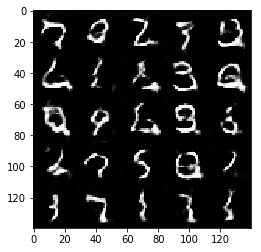

Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.7418
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.7265
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.6680
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.6820
Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 0.8030
Tensor("input_z:0", shape=(?, 112), dtype=float32)


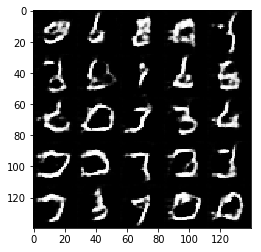

Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.6618
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.7381
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 0.7213
Epoch 2/2... Discriminator Loss: 1.2436... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.6309
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.8691
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.7062
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.3362... Generator Loss: 0.6521
Tensor("input_z:0", shape=(?, 112), dtype=float32)


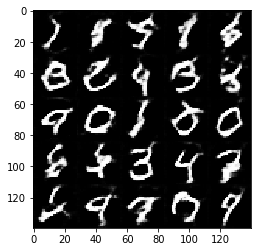

Epoch 2/2... Discriminator Loss: 1.5792... Generator Loss: 0.6025
Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.4754... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 0.8109
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 0.5728
Epoch 2/2... Discriminator Loss: 1.3460... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.2915... Generator Loss: 0.7604
Tensor("input_z:0", shape=(?, 112), dtype=float32)


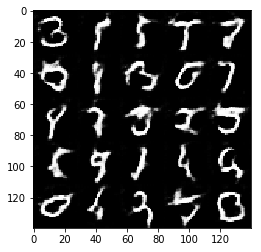

Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.5958
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.7617
Epoch 2/2... Discriminator Loss: 1.2747... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.6390
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.5868
Tensor("input_z:0", shape=(?, 112), dtype=float32)


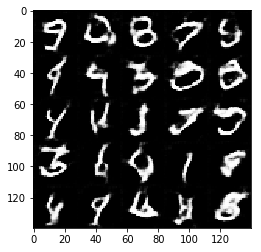

Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.6589
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.5406
Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 0.7138
Epoch 2/2... Discriminator Loss: 1.3560... Generator Loss: 0.8676
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.6040
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 1.2475... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.5932
Tensor("input_z:0", shape=(?, 112), dtype=float32)


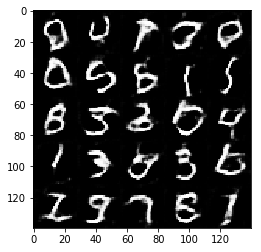

Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 0.6823
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 0.6864
Tensor("input_z:0", shape=(?, 112), dtype=float32)


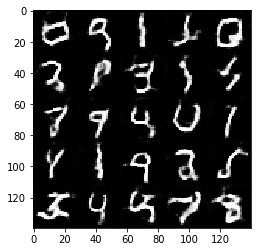

Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.4817... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 0.6424
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7692
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 0.6388
Epoch 2/2... Discriminator Loss: 1.2775... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.7241
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.6028
Tensor("input_z:0", shape=(?, 112), dtype=float32)


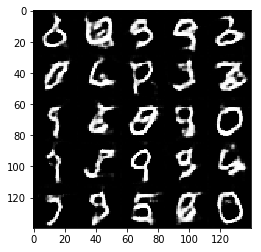

Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.6407
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.8029
Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.6488
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.6641
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.8066
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.3447... Generator Loss: 0.6878
Tensor("input_z:0", shape=(?, 112), dtype=float32)


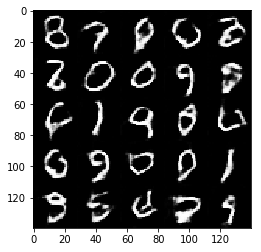

Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.5756
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.6253
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.7283
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.7495
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.6823
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.5838
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.8487
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.6898
Tensor("input_z:0", shape=(?, 112), dtype=float32)


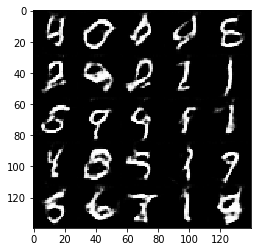

Epoch 2/2... Discriminator Loss: 1.2770... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.6209
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.3560... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 0.8120
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.6239
Tensor("input_z:0", shape=(?, 112), dtype=float32)


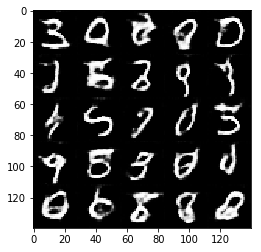

Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 0.6734
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 0.7246
Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.5649... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 1.2612... Generator Loss: 0.7963
Tensor("input_z:0", shape=(?, 112), dtype=float32)


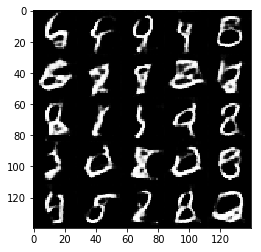

Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.5948
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.2402... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 1.3169... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.6837
Tensor("input_z:0", shape=(?, 112), dtype=float32)


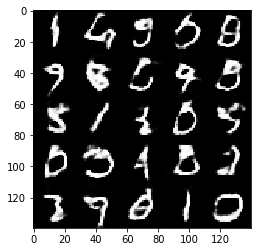

Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.7282
Epoch 2/2... Discriminator Loss: 1.4057... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.6237
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.5979
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.3665... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.7446
Tensor("input_z:0", shape=(?, 112), dtype=float32)


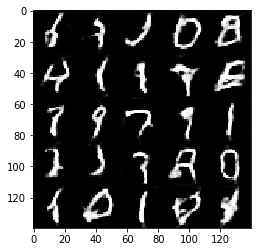

Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.6172
Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.5670
Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.5572
Tensor("input_z:0", shape=(?, 112), dtype=float32)


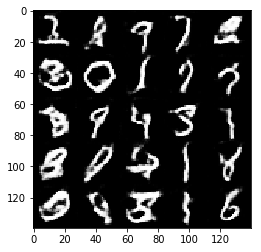

Epoch 2/2... Discriminator Loss: 1.3197... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.3560... Generator Loss: 0.7294
Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 0.7363
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 0.7363
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.6980
Tensor("input_z:0", shape=(?, 112), dtype=float32)


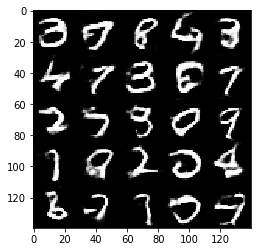

Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 0.8863
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.7366
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 1.3169... Generator Loss: 0.6231
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.5949
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.6779
Tensor("input_z:0", shape=(?, 112), dtype=float32)


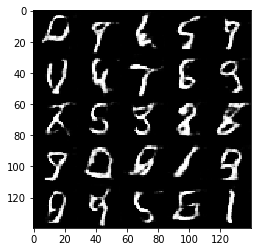

Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.7976
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.5945
Epoch 2/2... Discriminator Loss: 1.3360... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.2230... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 1.3232... Generator Loss: 0.6167
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.8089
Tensor("input_z:0", shape=(?, 112), dtype=float32)


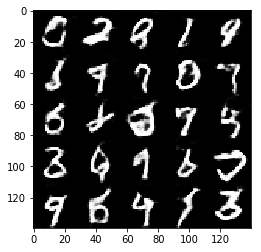

Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6224
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 1.4861... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.6180
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.5952
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 0.5514
Tensor("input_z:0", shape=(?, 112), dtype=float32)


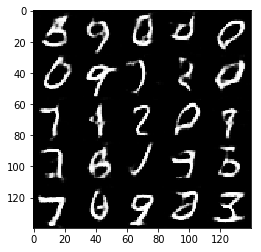

Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 0.6614
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.6264
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.7482
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.6730
Epoch 2/2... Discriminator Loss: 1.2258... Generator Loss: 0.7123
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 0.6200
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.6231
Tensor("input_z:0", shape=(?, 112), dtype=float32)


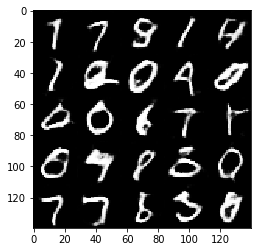

Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.5821
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.6348
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.6286


In [29]:
batch_size = 32
z_dim = 112
learning_rate = 0.0002
beta1 = 0.2
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 28, 28, 3)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
(?, 28, 28, 3) (?, 28, 28, 3)
(?, 28, 28, 3)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.8155
Tensor("input_z:0", shape=(?, 112), dtype=float32)


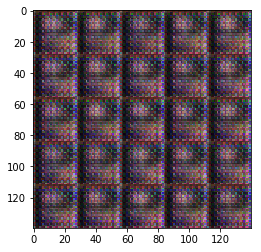

Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7665
Tensor("input_z:0", shape=(?, 112), dtype=float32)


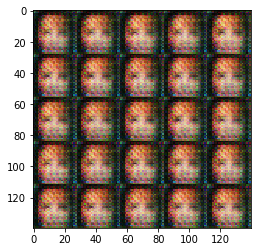

Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.4412
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.2666
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.4377
Tensor("input_z:0", shape=(?, 112), dtype=float32)


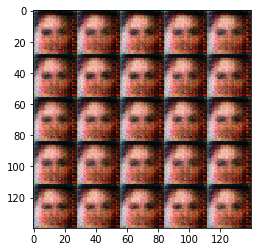

Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 1.4151
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.4792
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.7094
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.4045
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.7086
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.6884
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 1.6832
Tensor("input_z:0", shape=(?, 112), dtype=float32)


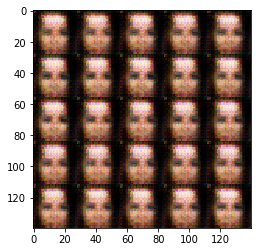

Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.5771
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.7268
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 1.2227
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.4856
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 1.5425
Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 1.6437
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 1.6448
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 1.9945
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 1.4560
Tensor("input_z:0", shape=(?, 112), dtype=float32)


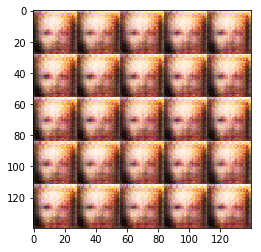

Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.6071
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.5271
Tensor("input_z:0", shape=(?, 112), dtype=float32)


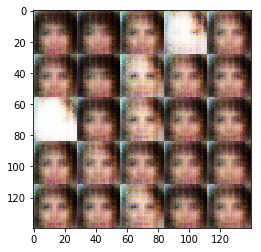

Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.8622
Tensor("input_z:0", shape=(?, 112), dtype=float32)


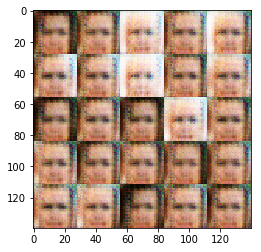

Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 1.0508
Tensor("input_z:0", shape=(?, 112), dtype=float32)


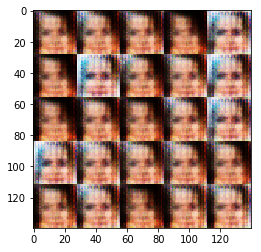

Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.4930
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 2.6048
Tensor("input_z:0", shape=(?, 112), dtype=float32)


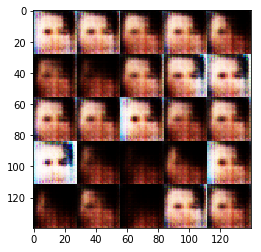

Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.5123
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.8490
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.6679
Tensor("input_z:0", shape=(?, 112), dtype=float32)


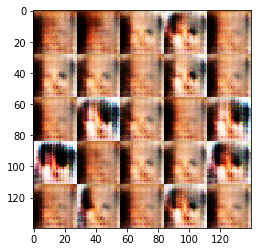

Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 1.8033
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.9931
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.8303
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.9811
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.2436
Tensor("input_z:0", shape=(?, 112), dtype=float32)


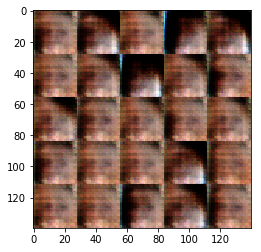

Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 2.0926
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.0955
Tensor("input_z:0", shape=(?, 112), dtype=float32)


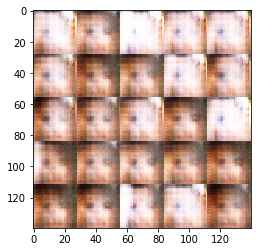

Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.3387
Tensor("input_z:0", shape=(?, 112), dtype=float32)


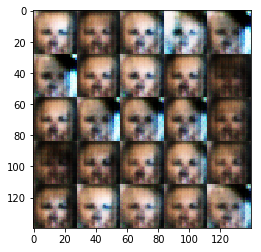

Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.7905
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.5703
Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 1.3270
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 1.1205
Tensor("input_z:0", shape=(?, 112), dtype=float32)


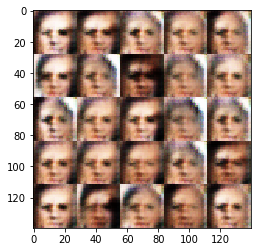

Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 2.4069
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.6422
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.3549
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.3925
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.8288
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.1877
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7183
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.8427
Tensor("input_z:0", shape=(?, 112), dtype=float32)


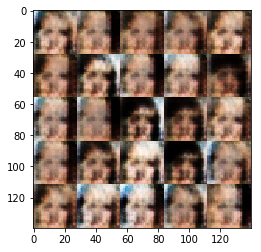

Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6167
Tensor("input_z:0", shape=(?, 112), dtype=float32)


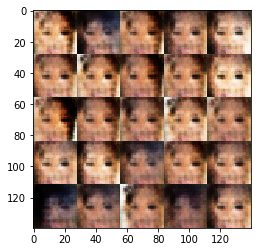

Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 1.9673
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.6197
Tensor("input_z:0", shape=(?, 112), dtype=float32)


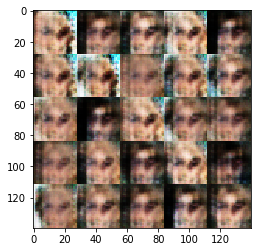

Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.9883
Tensor("input_z:0", shape=(?, 112), dtype=float32)


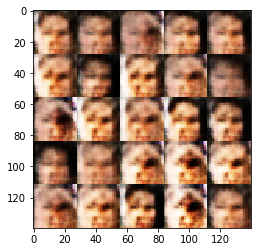

Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.2422
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.1834
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 1.1255
Tensor("input_z:0", shape=(?, 112), dtype=float32)


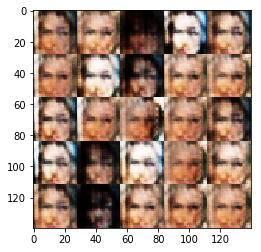

Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.6721
Tensor("input_z:0", shape=(?, 112), dtype=float32)


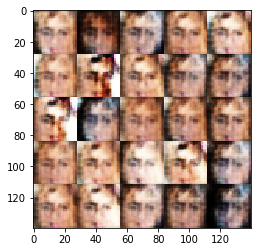

Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.4377
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.2396
Tensor("input_z:0", shape=(?, 112), dtype=float32)


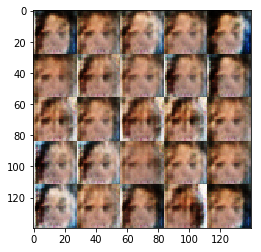

Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.3817
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.8910
Tensor("input_z:0", shape=(?, 112), dtype=float32)


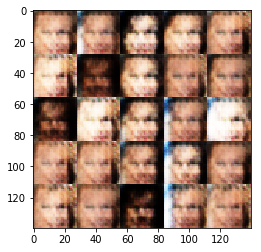

Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 1.2771
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.7401
Tensor("input_z:0", shape=(?, 112), dtype=float32)


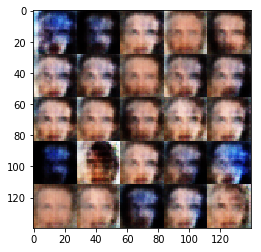

Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.8713
Tensor("input_z:0", shape=(?, 112), dtype=float32)


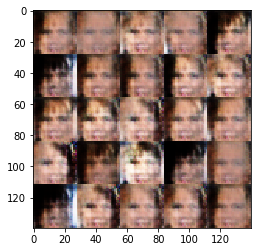

Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.5613
Tensor("input_z:0", shape=(?, 112), dtype=float32)


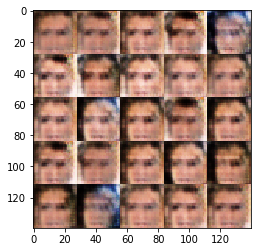

Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.6846
Tensor("input_z:0", shape=(?, 112), dtype=float32)


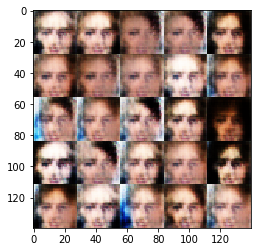

Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.3232
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.3906
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.0835
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.2861
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.9957
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 1.6149... Generator Loss: 0.3512
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6622
Tensor("input_z:0", shape=(?, 112), dtype=float32)


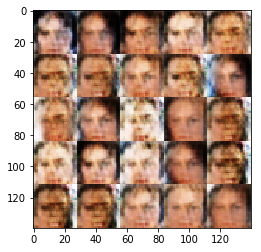

Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.8564
Tensor("input_z:0", shape=(?, 112), dtype=float32)


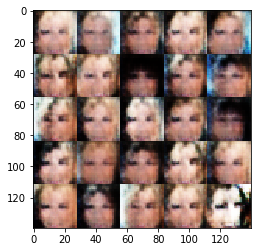

Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.6247
Tensor("input_z:0", shape=(?, 112), dtype=float32)


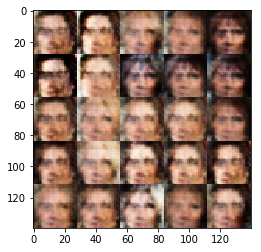

Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.6543
Tensor("input_z:0", shape=(?, 112), dtype=float32)


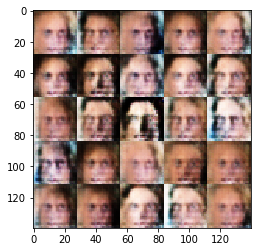

Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.5871... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8036
Tensor("input_z:0", shape=(?, 112), dtype=float32)


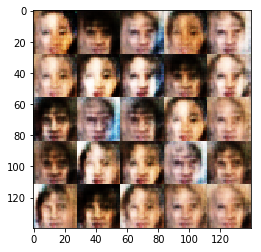

Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.8756
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.8150
Tensor("input_z:0", shape=(?, 112), dtype=float32)


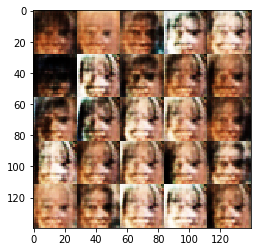

Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.2487
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.5442
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.8437
Tensor("input_z:0", shape=(?, 112), dtype=float32)


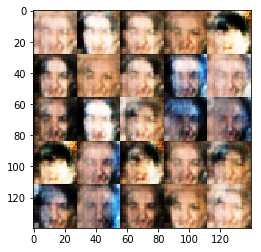

Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.6553... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.5789
Tensor("input_z:0", shape=(?, 112), dtype=float32)


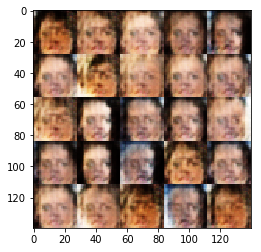

Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.7056
Tensor("input_z:0", shape=(?, 112), dtype=float32)


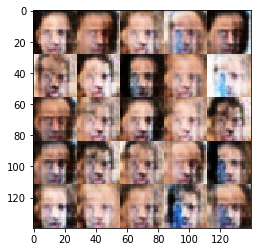

Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8826
Tensor("input_z:0", shape=(?, 112), dtype=float32)


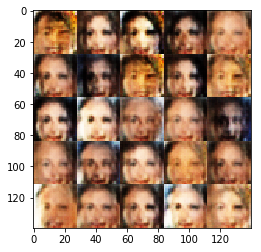

Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.6155
Tensor("input_z:0", shape=(?, 112), dtype=float32)


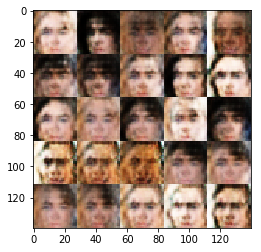

Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6661
Tensor("input_z:0", shape=(?, 112), dtype=float32)


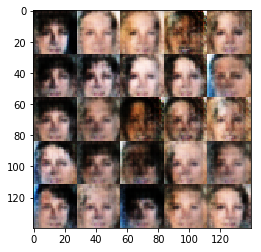

Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7575
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.7273
Tensor("input_z:0", shape=(?, 112), dtype=float32)


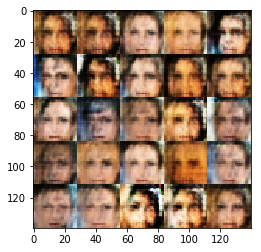

Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6417
Tensor("input_z:0", shape=(?, 112), dtype=float32)


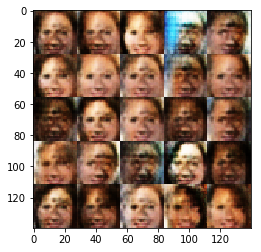

Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.8855
Tensor("input_z:0", shape=(?, 112), dtype=float32)


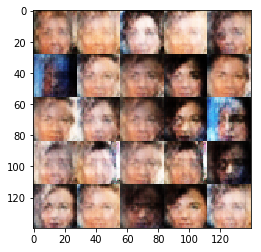

Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.7247
Tensor("input_z:0", shape=(?, 112), dtype=float32)


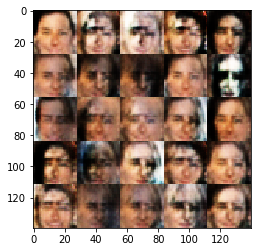

Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7252
Tensor("input_z:0", shape=(?, 112), dtype=float32)


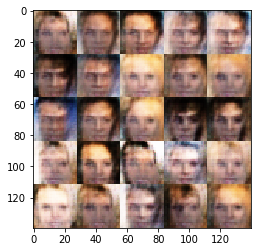

Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9559
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7436
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6766
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.5892
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.9689
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7982
Tensor("input_z:0", shape=(?, 112), dtype=float32)


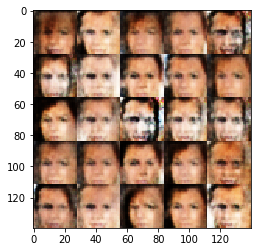

Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.7189
Tensor("input_z:0", shape=(?, 112), dtype=float32)


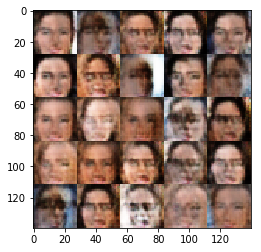

Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7824
Tensor("input_z:0", shape=(?, 112), dtype=float32)


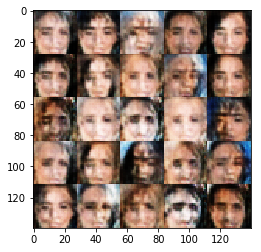

Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7280
Tensor("input_z:0", shape=(?, 112), dtype=float32)


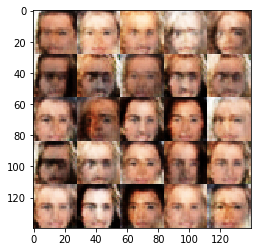

Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8786
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6857
Tensor("input_z:0", shape=(?, 112), dtype=float32)


Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7330
Tensor("input_z:0", shape=(?, 112), dtype=float32)


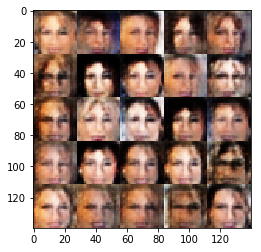

Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8304


In [32]:
batch_size = 32
z_dim = 112
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.